In [1]:
import muon as mu
from muon import atac as ac
import numpy as np
import scanpy as sc
import episcanpy as epi
import anndata as ad

In [2]:
adata = sc.read("/ailab/user/sunjianle-hdd/integration27/mop/GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad")
adata.X = adata.layers['counts']
adata.obs['cellid'] = list(range(adata.n_obs))
# # adata.obsm = {}
# # adata.layers.clear()

In [3]:
rna = adata[:,adata.var.index[adata.var.feature_types == 'GEX']]
atac = adata[:,adata.var.index[adata.var.feature_types == 'ATAC']]
rna.obsm = {key: rna.obsm[key] for key in ["GEX_X_pca", "GEX_X_umap"] if key in rna.obsm}
atac.obsm = {key: atac.obsm[key] for key in ['ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap'] if key in atac.obsm}
# shared_obs_names = rna.obs_names.intersection(atac.obs_names)
# shared_obs = adata_rna.obs.loc[shared_obs_names].copy()
# mdata = mu.MuData({"rna": adata_rna, "atac": adata_atac})
# mdata.obs = shared_obs

In [4]:
rna

AnnData object with n_obs × n_vars = 69249 × 13431
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'cellid'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [5]:
atac

AnnData object with n_obs × n_vars = 69249 × 116490
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'cellid'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap'
    layers: 'counts'

In [73]:
# rna = mdata.mod['rna']
# atac = mdata.mod['atac']
# common_cells = rna.obs_names.intersection(atac.obs_names)
# rna = rna[common_cells,:]
# atac = atac[common_cells,:]

deal with scRNA data

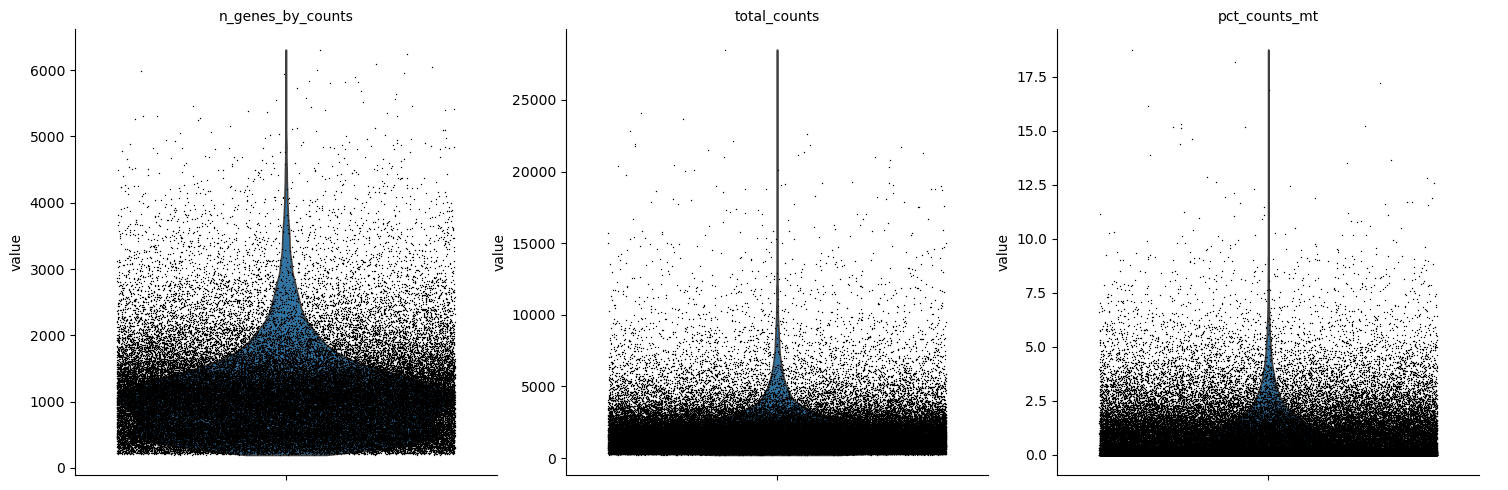

In [6]:
rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [7]:
# mu.pp.filter_var(rna, 'n_cells_by_counts', lambda x: x >= 3)
# mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 200) & (x < 5000))
# mu.pp.filter_obs(rna, 'total_counts', lambda x: x < 15000)
# mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < 20)

sc.pp.filter_genes(rna, min_cells=3)
sc.pp.filter_cells(rna, min_genes=200)
sc.pp.filter_cells(rna, max_genes=5000)
sc.pp.filter_cells(rna, max_counts=15000)
rna = rna[rna.obs['pct_counts_mt'] < 20, :]
rna.layers['counts'] = rna.X.copy()

In [8]:
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
sc.pp.highly_variable_genes(rna, batch_key="batch", min_mean=0.02, max_mean=4, min_disp=0.5)
genelist = rna.var.index[rna.var['highly_variable']==True]

deal with scATAC data

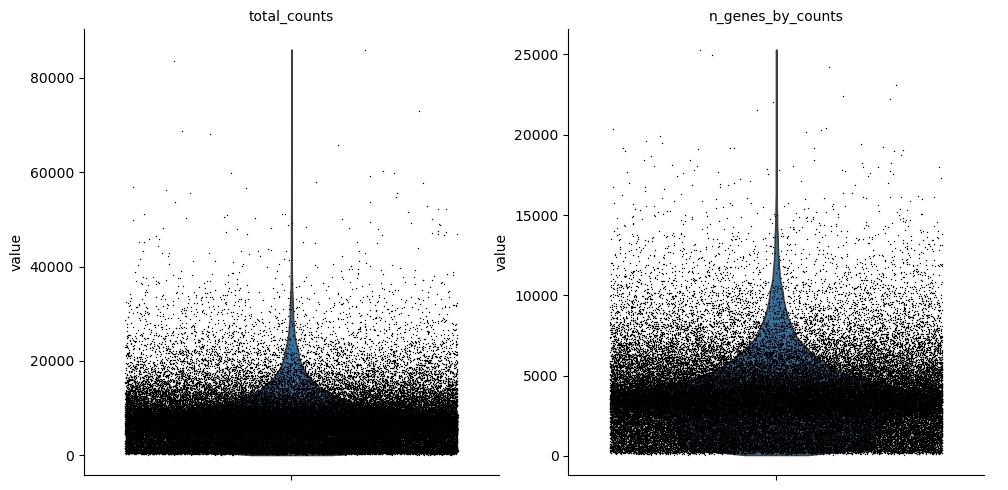

In [9]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)
sc.pl.violin(atac, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)

In [10]:
# mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)
# mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 2000) & (x <= 15000))
sc.pp.filter_genes(atac, min_cells=10)
sc.pp.filter_cells(atac, min_genes=2000)
sc.pp.filter_cells(atac, max_genes=15000)
atac.layers["counts"] = atac.X.copy()

In [11]:
ac.pp.tfidf(atac, scale_factor=1e4)
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=.5, batch_key="batch")
peaklist = atac.var.index[atac.var['highly_variable']==True]

In [12]:
atac.var_names

Index(['chr1-9776-10668', 'chr1-180726-181005', 'chr1-181117-181803',
       'chr1-191133-192055', 'chr1-267562-268456', 'chr1-629497-630394',
       'chr1-633515-634474', 'chr1-778276-779191', 'chr1-816868-817761',
       'chr1-822804-823597',
       ...
       'GL000195.1-137376-138301', 'GL000219.1-39933-40839',
       'GL000219.1-42172-43054', 'GL000219.1-44703-45584',
       'GL000219.1-45726-46450', 'GL000219.1-90062-90937',
       'GL000219.1-99257-100160', 'KI270726.1-27152-28034',
       'KI270713.1-21434-22336', 'KI270713.1-29629-30491'],
      dtype='object', length=116490)

In [13]:
atac.var_names = [name.replace("-", ":", 1) for name in atac.var_names]

In [14]:
atac.var_names

Index(['chr1:9776-10668', 'chr1:180726-181005', 'chr1:181117-181803',
       'chr1:191133-192055', 'chr1:267562-268456', 'chr1:629497-630394',
       'chr1:633515-634474', 'chr1:778276-779191', 'chr1:816868-817761',
       'chr1:822804-823597',
       ...
       'GL000195.1:137376-138301', 'GL000219.1:39933-40839',
       'GL000219.1:42172-43054', 'GL000219.1:44703-45584',
       'GL000219.1:45726-46450', 'GL000219.1:90062-90937',
       'GL000219.1:99257-100160', 'KI270726.1:27152-28034',
       'KI270713.1:21434-22336', 'KI270713.1:29629-30491'],
      dtype='object', length=116490)

In [15]:
atac

AnnData object with n_obs × n_vars = 51650 × 116490
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'cellid', 'n_genes_by_counts', 'total_counts', 'n_genes'
    var: 'feature_types', 'gene_id', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'hvg'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap'
    layers: '

In [16]:
# data after QC
rna.write_h5ad("/ailab/user/sunjianle-hdd/integration27/mop/BMMC/RNA_counts_qc.h5ad")
atac.write_h5ad("/ailab/user/sunjianle-hdd/integration27/mop/BMMC/ATAC_counts_qc.h5ad")

combine data

In [17]:
# rna = rna[common_cells,:]
# atac = atac[common_cells,:]
# mdata = mu.MuData({"rna": rna, "atac": atac})
# mdata
# mdata.write("/ailab/user/sunjianle-hdd/integration27/BMMC/data/mdata_qc.h5mu")

In [18]:
# # data after QC and feature selection
# mdata_filtered = mu.MuData({"rna": rna[common_cells,genelist], "atac": atac[common_cells,peaklist]})
# mdata_filtered
# shared_obs = rna[common_cells,:].obs.copy()
# mdata_filtered.obs = shared_obs
# mdata_filtered.write("/ailab/user/sunjianle-hdd/integration27/BMMC/data/mdata_filtered.h5mu")

In [19]:
atac = sc.read("/ailab/user/sunjianle-hdd/integration27/mop/BMMC/ATAC_counts_qc.h5ad")
# chromosomes = [name.split("-")[0] for name in atac.var_names]
# standard_chromosomes = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
# valid_idx = [i for i, chrom in enumerate(chromosomes) if chrom in standard_chromosomes]
# atac = atac[:, valid_idx]
atac.layers['normalized'] = atac.X.copy()
atac.X = atac.layers['counts'].copy()
atac_gas = epi.tl.geneactivity(atac, "/ailab/user/sunjianle-hdd/integration27/BMMC/gencode.v38.primary_assembly.annotation.gtf",annotation='HAVANA')
atac_gas = atac_gas[:, ~atac_gas.var_names.duplicated()]

In [20]:
atac_gas.layers['counts'] = atac_gas.X.copy()
ac.pp.tfidf(atac_gas, scale_factor=1e4)
sc.pp.highly_variable_genes(atac_gas) 

In [21]:
atac_gas.write("/ailab/user/sunjianle-hdd/integration27/mop/BMMC/ATAC_gas.h5ad")

Another

In [43]:
adata = sc.read("/ailab/user/sunjianle-hdd/integration27/mop/GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad")
adata.X = adata.layers['counts']
adata.obs['cellid'] = list(range(adata.n_obs))

In [44]:
adata

AnnData object with n_obs × n_vars = 90261 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'cellid'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [45]:
adata.var.feature_types

AL627309.5    GEX
LINC01409     GEX
LINC01128     GEX
LINC00115     GEX
FAM41C        GEX
             ... 
HLA-E         ADT
CD82          ADT
CD101         ADT
CD88          ADT
CD224         ADT
Name: feature_types, Length: 14087, dtype: category
Categories (2, object): ['ADT', 'GEX']

In [46]:
p = len(adata.var.index[adata.var.feature_types == 'GEX'])

In [52]:
len(adata.var.index[adata.var.feature_types == 'ADT'])

134

In [47]:
rna = adata[:,:p]  #[:,adata.var.index[adata.var.feature_types == 'GEX']]
prot = adata[:,p:]  #[:,adata.var.index[adata.var.feature_types == 'ADT']]
rna.obsm = {key: rna.obsm[key] for key in ["GEX_X_pca", "GEX_X_umap"] if key in rna.obsm}
prot.obsm = {key: prot.obsm[key] for key in ['ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls'] if key in prot.obsm}

In [48]:
rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.filter_genes(rna, min_cells=3)
sc.pp.filter_cells(rna, min_genes=200)
sc.pp.filter_cells(rna, max_genes=5000)
sc.pp.filter_cells(rna, max_counts=15000)
rna = rna[rna.obs['pct_counts_mt'] < 20, :]
rna.layers['counts'] = rna.X.copy()
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
sc.pp.highly_variable_genes(rna, batch_key="batch", min_mean=0.02, max_mean=4, min_disp=0.5)
genelist = rna.var.index[rna.var['highly_variable']==True]

In [50]:
from muon import prot as pt
prot.layers['counts'] = prot.X.copy()
pt.pp.clr(prot)

In [51]:
prot

AnnData object with n_obs × n_vars = 90261 × 134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'cellid'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls'
    layers: 'counts'

In [58]:
rna1 = sc.read("/ailab/user/sunjianle-hdd/integration27/mop/BMMC/RNA_counts_qc.h5ad")

In [56]:
rna = ad.concat([rna1,rna])
rna

AnnData object with n_obs × n_vars = 152431 × 12059
    obs: 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'cell_type', 'batch', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'cellid', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts'
    obsm: 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [57]:
rna.write_h5ad("/ailab/user/sunjianle-hdd/integration27/mop/BMMC/RNA_counts_qc.h5ad")
prot.write_h5ad("/ailab/user/sunjianle-hdd/integration27/mop/BMMC/protein_counts_qc.h5ad")

combine

In [59]:
# 更新的最终标签映射字典（包含 B cell vs Plasma cell 区分）
final_celltype_mapping = {
    # CD4 T
    'CD4+ T naive': 'CD4 T',
    'CD4+ T activated': 'CD4 T',
    'CD4+ T activated integrinB7+': 'CD4 T',
    'CD4+ T CD314+ CD45RA+': 'CD4 T',
    'T reg': 'CD4 T',
    
    # CD8 T
    'CD8+ T naive': 'CD8 T',
    'CD8+ T naive CD127+ CD26- CD101-': 'CD8 T',
    'CD8+ T CD49f+': 'CD8 T',
    'CD8+ T TIGIT+ CD45RO+': 'CD8 T',
    'CD8+ T CD57+ CD45RA+': 'CD8 T',
    'CD8+ T CD69+ CD45RO+': 'CD8 T',
    'CD8+ T TIGIT+ CD45RA+': 'CD8 T',
    'CD8+ T CD69+ CD45RA+': 'CD8 T',
    'CD8+ T CD57+ CD45RO+': 'CD8 T',
    'CD8+ T': 'CD8 T',
    'MAIT': 'CD8 T',
    'gdT TCRVD2+': 'CD8 T',
    'gdT CD158b+': 'CD8 T',
    'dnT': 'CD8 T',

    # B cells
    'Naive CD20+ B IGKC+': 'B cell',
    'Naive CD20+ B IGKC-': 'B cell',
    'Naive CD20+ B': 'B cell',
    'B1 B IGKC+': 'B cell',
    'B1 B IGKC-': 'B cell',
    'B1 B': 'B cell',
    'Transitional B': 'B cell',

    # Plasma cells
    'Plasmablast IGKC+': 'Plasma cell',
    'Plasmablast IGKC-': 'Plasma cell',
    'Plasma cell IGKC+': 'Plasma cell',
    'Plasma cell IGKC-': 'Plasma cell',
    'Plasma cell': 'Plasma cell',

    # NK
    'NK': 'NK',
    'NK CD158e1+': 'NK',

    # Mono
    'CD14+ Mono': 'Mono',
    'CD16+ Mono': 'Mono',

    # DC
    'pDC': 'DC',
    'cDC1': 'DC',
    'cDC2': 'DC',

    # ILC
    'ILC': 'ILC',
    'ILC1': 'ILC',

    # Progenitors
    'HSC': 'Progenitor',
    'Lymph prog': 'Progenitor',
    'G/M prog': 'Progenitor',
    'MK/E prog': 'Progenitor',
    'ID2-hi myeloid prog': 'Progenitor',
    'T prog cycling': 'Progenitor',

    # Erythroid
    'Erythroblast': 'Erythroid',
    'Normoblast': 'Erythroid',
    'Proerythroblast': 'Erythroid',
    'Reticulocyte': 'Erythroid',
}


In [105]:
rna = sc.read("/ailab/user/sunjianle-hdd/integration27/mop/BMMC/RNA_counts_qc.h5ad")
atac_gas = sc.read("/ailab/user/sunjianle-hdd/integration27/mop/BMMC/ATAC_gas.h5ad")
atac = sc.read("/ailab/user/sunjianle-hdd/integration27/mop/BMMC/ATAC_counts_qc.h5ad")
prot = sc.read("/ailab/user/sunjianle-hdd/integration27/mop/BMMC/protein_counts_qc.h5ad")

In [106]:
rna.obs['celltype'] = rna.obs['cell_type'].map(final_celltype_mapping)
atac_gas.obs['celltype'] = atac_gas.obs['cell_type'].map(final_celltype_mapping)
atac.obs['celltype'] = atac.obs['cell_type'].map(final_celltype_mapping)
prot.obs['celltype'] = prot.obs['cell_type'].map(final_celltype_mapping)

In [107]:
import pandas as pd
df_hgnc = pd.read_csv("/ailab/user/sunjianle/integration26/group-471.csv")
df_hgnc

,HGNC ID (gene),Approved symbol,Approved name,Previous symbols,Aliases,Chromosome
0,HGNC:1634,CD1A,CD1a molecule,CD1,NaN,1q23.1
1,HGNC:1635,CD1B,CD1b molecule,CD1,NaN,1q23.1
2,HGNC:1636,CD1C,CD1c molecule,CD1,NaN,1q23.1
3,HGNC:1637,CD1D,CD1d molecule,NaN,NaN,1q23.1
4,HGNC:1638,CD1E,CD1e molecule,NaN,NaN,1q23.1
...,...,...,...,...,...,...
389,HGNC:13257,CLEC4A,C-type lectin domain family 4 member A,CLECSF6,"DCIR,DDB27,CD367,hDCIR",12p13.31
390,HGNC:14554,CLEC4D,C-type lectin domain family 4 member D,CLECSF8,"Mpcl,CD368,MCL,Dectin-3",12p13.31
391,HGNC:14558,CLEC7A,C-type lectin domain containing 7A,CLECSF12,"DECTIN-1,hDectin-1,CD369,SCARE2",12p13.2
392,HGNC:26705,CLEC9A,C-type lectin domain containing 9A,NaN,"UNQ9341,HEEE9341,CD370,DNGR-1",12p13.2


In [108]:
cd_list = prot.var.index.tolist()
df_hgnc[['Previous symbols', 'Aliases']] = df_hgnc[['Previous symbols', 'Aliases']].fillna('')

def map_cd_name(cd):
    for _, row in df_hgnc.iterrows():
        approved = row['Approved symbol']
        prev = [s.strip() for s in str(row['Previous symbols']).split(',')]
        aliases = [s.strip() for s in str(row['Aliases']).split(',')]

        if cd == approved or cd in prev or cd in aliases:
            return approved
    return cd  # 若找不到，则保留原始名称

# 应用映射
mapped_cd_list = [map_cd_name(cd) for cd in cd_list]

# 结果放入DataFrame中
df_result = pd.DataFrame({'Original': cd_list, 'Mapped Gene Symbol': mapped_cd_list})

# 可选：查看哪些没有映射成功
unmapped = df_result[df_result['Original'] == df_result['Mapped Gene Symbol']]

In [109]:
prot.var['cd_name'] = prot.var.index
prot.var['gene_name'] = mapped_cd_list
prot.var.index = prot.var['gene_name']

In [110]:
# import mygene
# import pandas as pd

# mg = mygene.MyGeneInfo()
# protein_list = prot.var.index.tolist()
# results = mg.querymany(protein_list, scopes='symbol', species='human',
#                        fields="symbol,name,genomic_pos,chromosome", as_dataframe=True)
# df = results.reset_index()[['query', 'symbol', 'name', 'chromosome', 'genomic_pos.chr', 'genomic_pos.start', 'genomic_pos.end']]
# df.columns = ['query', 'symbol', 'name', 'chromosome', 'chr', 'start', 'end']

In [111]:
# import scglue
# scglue.data.get_gene_annotation(
#     prot, gtf="/ailab/user/sunjianle-hdd/integration27/BMMC/gencode.v38.chr_patch_hapl_scaff.annotation.gtf",
#     gtf_by="gene_name"
# )

In [112]:
prot.var

,feature_types,gene_id,cd_name,gene_name
gene_name,,,,
CD86,ADT,ENSG00000114013,CD86,CD86
CD274,ADT,NaN,CD274,CD274
TNFRSF14,ADT,NaN,CD270,TNFRSF14
PVR,ADT,NaN,CD155,PVR
NECTIN2,ADT,NaN,CD112,NECTIN2
...,...,...,...,...
HLA-E,ADT,ENSG00000204592,HLA-E,HLA-E
CD82,ADT,ENSG00000085117,CD82,CD82
CD101,ADT,ENSG00000134256,CD101,CD101


In [114]:
len(set(prot.var.index)& set(atac_gas.var.index) & set(rna.var.index))

96

In [116]:
sc.pp.highly_variable_genes(rna, batch_key="batch", min_mean=0.02, max_mean=4, min_disp=0.5)
genelist = rna.var.index[rna.var['highly_variable']==True]
peaklist = atac_gas.var.index[atac_gas.var['highly_variable']==True]
genelist2 = list((set(peaklist) | set(genelist) | set(prot.var.index)))

In [117]:
rna.write_h5ad("/ailab/user/sunjianle-hdd/integration27/mop/BMMC/RNA_counts_qc.h5ad")
atac_gas.write_h5ad("/ailab/user/sunjianle-hdd/integration27/mop/BMMC/ATAC_gas.h5ad")
atac.write_h5ad("/ailab/user/sunjianle-hdd/integration27/mop/BMMC/ATAC_counts_qc.h5ad")
prot.write_h5ad("/ailab/user/sunjianle-hdd/integration27/mop/BMMC/protein_counts_qc.h5ad")

In [118]:
adata = ad.concat([rna,atac_gas,prot], join='outer', label="modality")
adata

AnnData object with n_obs × n_vars = 294342 × 31742
    obs: 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'cell_type', 'batch', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'cellid', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'celltype', 'GEX_n_counts', 'GEX_n_genes', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'ATAC_pseudotime_order', 'GEX_n_genes_by_counts', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'ADT_pseudotime_order', 'is_train', 'modality'
    obsm: 'GEX_X_pca', 'GEX_X_umap', 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls'
    layers: 'counts'

In [127]:
adata.uns['rna_hvg'] = genelist.tolist()
adata.uns['atac_hvg'] = peaklist.tolist()
adata.uns['prot_hvg'] = prot.var.index.tolist()
adata.uns['rna_nz'] = list(set(genelist2) & set(rna.var.index))
adata.uns['atac_nz'] = list(set(genelist2) & set(atac_gas.var.index))
adata.uns['prot_nz'] = list(set(genelist2) & set(prot.var.index))

In [120]:
adata.obs.celltype.unique()

['B cell', 'Mono', 'CD8 T', 'Progenitor', 'CD4 T', 'Erythroid', 'NK', 'ILC', 'DC', 'Plasma cell']
Categories (10, object): ['B cell', 'CD4 T', 'CD8 T', 'DC', ..., 'Mono', 'NK', 'Plasma cell', 'Progenitor']

In [128]:
adata[:,genelist2]

View of AnnData object with n_obs × n_vars = 294342 × 10158
    obs: 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'cell_type', 'batch', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'cellid', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'celltype', 'GEX_n_counts', 'GEX_n_genes', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'ATAC_pseudotime_order', 'GEX_n_genes_by_counts', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'ADT_pseudotime_order', 'is_train', 'modality'
    uns: 'rna_hvg', 'atac_hvg', 'prot_hvg', 'rna_nz', 'atac_nz', 'prot_nz'
    obsm: 'GEX_X_pca', 'GEX_X_umap', 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'ADT_X_pca', 'ADT_X_umap', 'ADT_

In [129]:
adata[:,genelist2].write_h5ad("/ailab/user/sunjianle-hdd/integration27/mop/BMMC/feature_aligned.h5ad")

sample

In [2]:
rna = sc.read("/ailab/user/sunjianle-hdd/integration27/mop/BMMC/RNA_counts_qc.h5ad")
atac_gas = sc.read("/ailab/user/sunjianle-hdd/integration27/mop/BMMC/ATAC_gas.h5ad")
atac = sc.read("/ailab/user/sunjianle-hdd/integration27/mop/BMMC/ATAC_counts_qc.h5ad")
prot = sc.read("/ailab/user/sunjianle-hdd/integration27/mop/BMMC/protein_counts_qc.h5ad")

In [4]:
cell_indices_rna = np.arange(rna.n_obs)
sample_indices_rna = np.random.choice(
    cell_indices_rna, 
    size=int(0.2 * rna.n_obs), 
    replace=False
)
rna = rna[sample_indices_rna, :].copy()

cell_indices_atac = np.arange(atac.n_obs)
sample_indices_atac = np.random.choice(
    cell_indices_atac, 
    size=int(0.2 * atac.n_obs), 
    replace=False
)
atac = atac[sample_indices_atac, :].copy()
atac_gas = atac_gas[sample_indices_atac, :].copy()

cell_indices_prot = np.arange(prot.n_obs)
sample_indices_prot = np.random.choice(
    cell_indices_prot, 
    size=int(0.2 * prot.n_obs), 
    replace=False
)
prot = prot[sample_indices_prot, :].copy()

In [5]:
rna.write_h5ad("/ailab/user/sunjianle-hdd/integration27/mop/BMMC/RNA_counts_qc_sampled.h5ad")
atac_gas.write_h5ad("/ailab/user/sunjianle-hdd/integration27/mop/BMMC/ATAC_gas_sampled.h5ad")
atac.write_h5ad("/ailab/user/sunjianle-hdd/integration27/mop/BMMC/ATAC_counts_qc_sampled.h5ad")
prot.write_h5ad("/ailab/user/sunjianle-hdd/integration27/mop/BMMC/protein_counts_qc_sampled.h5ad")

In [6]:
adata = ad.concat([rna,atac_gas,prot], join='outer', label="modality")
adata

AnnData object with n_obs × n_vars = 58868 × 31742
    obs: 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'cell_type', 'batch', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'cellid', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'celltype', 'GEX_n_counts', 'GEX_n_genes', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'ATAC_pseudotime_order', 'GEX_n_genes_by_counts', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'ADT_pseudotime_order', 'is_train', 'modality'
    obsm: 'GEX_X_pca', 'GEX_X_umap', 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls'
    layers: 'counts'

In [7]:
genelist = rna.var.index[rna.var['highly_variable']==True]
peaklist = atac_gas.var.index[atac_gas.var['highly_variable']==True]
genelist2 = list((set(peaklist) | set(genelist) | set(prot.var.index)))
adata.uns['rna_hvg'] = genelist.tolist()
adata.uns['atac_hvg'] = peaklist.tolist()
adata.uns['prot_hvg'] = prot.var.index.tolist()
adata.uns['rna_nz'] = list(set(genelist2) & set(rna.var.index))
adata.uns['atac_nz'] = list(set(genelist2) & set(atac_gas.var.index))
adata.uns['prot_nz'] = list(set(genelist2) & set(prot.var.index))
adata = adata[:,genelist2]
adata

View of AnnData object with n_obs × n_vars = 58868 × 5097
    obs: 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'cell_type', 'batch', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'cellid', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'celltype', 'GEX_n_counts', 'GEX_n_genes', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'ATAC_pseudotime_order', 'GEX_n_genes_by_counts', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'ADT_pseudotime_order', 'is_train', 'modality'
    uns: 'rna_hvg', 'atac_hvg', 'prot_hvg', 'rna_nz', 'atac_nz', 'prot_nz'
    obsm: 'GEX_X_pca', 'GEX_X_umap', 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'ADT_X_pca', 'ADT_X_umap', 'ADT_is

In [8]:
adata.write_h5ad("/ailab/user/sunjianle-hdd/integration27/mop/BMMC/feature_aligned_sampled.h5ad")